In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Concatenate, Lambda, Dropout
import tensorflow as tf
import os

In [2]:
train_dir = r'C:\Users\Admin\Downloads\micro+gas+turbine+electrical+energy+prediction\train_extracted'
test_dir = r'C:\Users\Admin\Downloads\micro+gas+turbine+electrical+energy+prediction\test_extracted'

In [3]:
def load_all_csvs(path):
    csvs = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".csv"):
                df = pd.read_csv(os.path.join(root, file))
                csvs.append(df)
    return pd.concat(csvs, ignore_index=True)

train_data = load_all_csvs(train_dir)
test_data = load_all_csvs(test_dir)

In [4]:
print("Train Shape:", train_data.shape)
print("Test Shape:", test_data.shape)

Train Shape: (52940, 3)
Test Shape: (18285, 3)


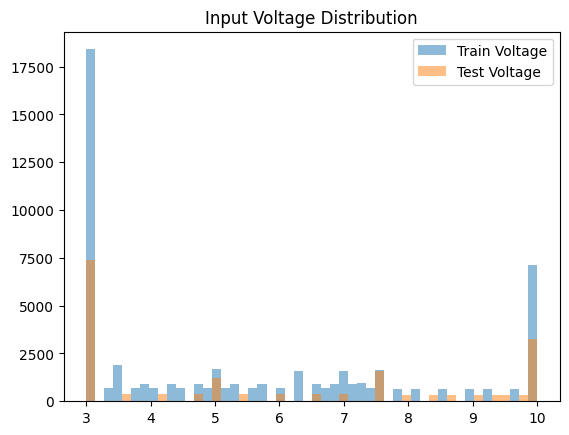

In [5]:
plt.hist(train_data['input_voltage'], bins=50, alpha=0.5, label='Train Voltage')
plt.hist(test_data['input_voltage'], bins=50, alpha=0.5, label='Test Voltage')
plt.legend()
plt.title("Input Voltage Distribution")
plt.show()

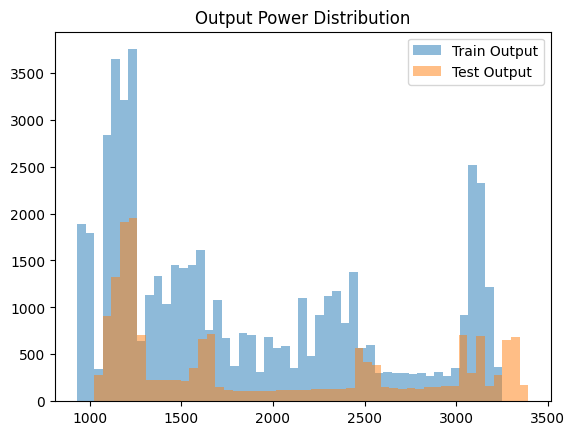

In [6]:
plt.hist(train_data['el_power'], bins=50, alpha=0.5, label='Train Output')
plt.hist(test_data['el_power'], bins=50, alpha=0.5, label='Test Output')
plt.legend()
plt.title("Output Power Distribution")
plt.show()

In [7]:
def create_sequences(df, seq_length=20):
    input_signal = df['input_voltage'].values
    derivative = np.diff(input_signal, prepend=input_signal[0])

    X, y = [], []
    combined = np.vstack([input_signal, derivative]).T

    for i in range(seq_length, len(df)):
        X.append(combined[i-seq_length:i])
        y.append(df['el_power'].values[i])

    return np.array(X), np.array(y)

In [8]:
X_train, y_train = create_sequences(train_data)
X_test, y_test = create_sequences(test_data)

print("Train Sequences Shape:", X_train.shape)
print("Test Sequences Shape:", X_test.shape)

Train Sequences Shape: (52920, 20, 2)
Test Sequences Shape: (18265, 20, 2)


In [9]:
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train.reshape(-1,1))
y_test_scaled = scaler.transform(y_test.reshape(-1,1))

In [10]:
def build_fixed_model():
    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
    x = LSTM(128, return_sequences=True)(input_layer)
    x = Dropout(0.2)(x)
    x = Attention()([x, x])
    x = Lambda(lambda z: z[:, -1, :])(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.1)(x)
    output = Dense(1)(x)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse')
    return model

In [11]:
model = build_fixed_model()
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 20, 2)]              0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 20, 128)              67072     ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 20, 128)              0         ['lstm[0][0]']                
                                                                                                  
 attention (Attention)       (None, 20, 128)              0         ['dropout[0][0]',             
                                                                     'dropout[0][0]']        

In [12]:
history = model.fit(X_train, y_train_scaled, validation_split=0.1, epochs=150, batch_size=64)

Epoch 1/150

745/745 [==============================] - 80s 93ms/step - loss: 0.0235 - val_loss: 0.0017
Epoch 2/150
745/745 [==============================] - 59s 79ms/step - loss: 0.0210 - val_loss: 0.0026
Epoch 3/150
745/745 [==============================] - 58s 78ms/step - loss: 0.0204 - val_loss: 0.0015
Epoch 4/150
745/745 [==============================] - 52s 69ms/step - loss: 0.0200 - val_loss: 0.0010
Epoch 5/150
745/745 [==============================] - 49s 65ms/step - loss: 0.0199 - val_loss: 0.0016
Epoch 6/150
745/745 [==============================] - 51s 68ms/step - loss: 0.0198 - val_loss: 0.0017
Epoch 7/150
745/745 [==============================] - 61s 82ms/step - loss: 0.0197 - val_loss: 0.0011
Epoch 8/150
745/745 [==============================] - 53s 71ms/step - loss: 0.0196 - val_loss: 0.0029
Epoch 9/150
745/745 [==============================] - 50s 67ms/step - loss: 0.0195 - val_loss: 0.0021
Epoch 10/150
745/745 [==============================] - 50s 67ms/step - 

571/571 [==============================] - 17s 20ms/step


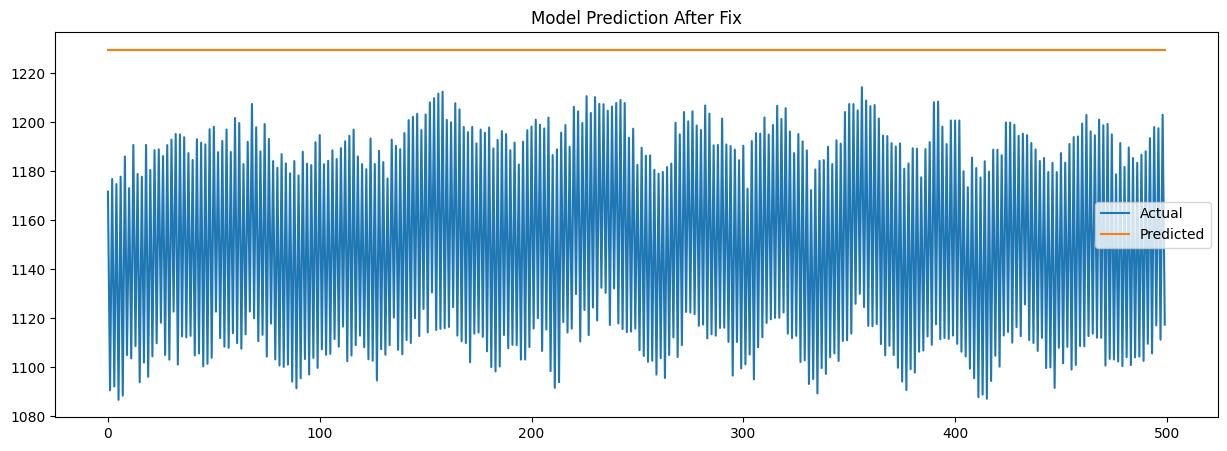

In [13]:
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test_scaled)

plt.figure(figsize=(15,5))
plt.plot(y_test_rescaled[:500], label='Actual')
plt.plot(y_pred_rescaled[:500], label='Predicted')
plt.legend()
plt.title("Model Prediction After Fix")
plt.show()

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print("RMSE:", np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled)))
print("MAE:", mean_absolute_error(y_test_rescaled, y_pred_rescaled))
print("R2:", r2_score(y_test_rescaled, y_pred_rescaled))

RMSE: 346.26745738031997
MAE: 191.43750441254213
R2: 0.8166467552233754


print("Train target range:", y_train.min(), "to", y_train.max())
print("Test target range:", y_test.min(), "to", y_test.max())

In [15]:
print("Train target range:", y_train.min(), "to", y_train.max())
print("Test target range:", y_test.min(), "to", y_test.max())


Train target range: 932.837260159588 to 3249.89121738983
Test target range: 1022.50030528342 to 3393.22856611123
